# section 1: Data parsing + processing

In [1]:
%matplotlib inline
trip_parsed = spark.read.csv(os.path.join(os.getcwd(), 'data/trip.csv'),
                             header=True,
                             inferSchema=True,
                             timestampFormat="MM/dd/YYYY HH:mm")

In [2]:
trip_parsed.select("id", "duration", "start_date", "start_station_id", "end_station_id").orderBy("id").show()

+----+--------+-------------------+----------------+--------------+
|  id|duration|         start_date|start_station_id|end_station_id|
+----+--------+-------------------+----------------+--------------+
|4069|     174|2013-08-29 09:08:00|              64|            64|
|4073|    1067|2013-08-29 09:24:00|              66|            69|
|4074|    1131|2013-08-29 09:24:00|              66|            69|
|4075|    1117|2013-08-29 09:24:00|              66|            69|
|4076|    1118|2013-08-29 09:25:00|              66|            69|
|4078|    3829|2013-08-29 09:31:00|              22|            22|
|4079|     995|2013-08-29 09:35:00|              66|            66|
|4080|     764|2013-08-29 09:36:00|              66|            69|
|4081|     218|2013-08-29 09:38:00|              27|            27|
|4084|     287|2013-08-29 09:41:00|              27|            27|
|4086|     178|2013-08-29 09:42:00|              45|            45|
|4100|    1392|2013-08-29 09:57:00|             

In [3]:
trip_parsed.printSchema()

root
 |-- id: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- start_date: timestamp (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_id: integer (nullable = true)
 |-- end_date: timestamp (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_id: integer (nullable = true)
 |-- bike_id: integer (nullable = true)
 |-- subscription_type: string (nullable = true)
 |-- zip_code: string (nullable = true)



In [4]:
from pyspark.sql.functions import desc
(trip_parsed
 .groupBy('start_station_id', 'end_station_id')
 .agg({'duration':'mean', '*':'count'})
 .sort(desc('count(1)'))
 .show())

+----------------+--------------+------------------+--------+
|start_station_id|end_station_id|     avg(duration)|count(1)|
+----------------+--------------+------------------+--------+
|              69|            65| 317.3016409266409|    6216|
|              50|            60|1264.3875730045424|    6164|
|              65|            70|285.19738147193016|    5041|
|              61|            50| 583.0818350898946|    4839|
|              50|            61|  668.652513197154|    4357|
|              60|            74| 542.5350199109862|    4269|
|              51|            70| 716.9868918578271|    3967|
|              74|            61| 576.7640276710223|    3903|
|              64|            77|  540.460711331679|    3627|
|              70|            50| 838.2711209276642|    3622|
|              55|            70|  654.953488372093|    3526|
|              70|            55| 738.8461538461538|    3510|
|              65|            69| 301.5959942775393|    3495|
|       

In [5]:
(trip_parsed
 .groupBy('start_station_name', 'end_station_name', 'subscription_type')
 .agg({'duration':'mean', '*':'count'})
 .where(trip_parsed.subscription_type == 'Subscriber')
 .sort(desc('count(1)'))
 .select('avg(duration)', 'start_station_name', 'end_station_name')
 .show(20, False))

+------------------+---------------------------------------------+---------------------------------------------+
|avg(duration)     |start_station_name                           |end_station_name                             |
+------------------+---------------------------------------------+---------------------------------------------+
|304.03355371900824|San Francisco Caltrain 2 (330 Townsend)      |Townsend at 7th                              |
|261.9496299342105 |Townsend at 7th                              |San Francisco Caltrain (Townsend at 4th)     |
|512.5369298448715 |2nd at Townsend                              |Harry Bridges Plaza (Ferry Building)         |
|601.6602139582272 |Harry Bridges Plaza (Ferry Building)         |2nd at Townsend                              |
|641.7166448230669 |Embarcadero at Folsom                        |San Francisco Caltrain (Townsend at 4th)     |
|406.83478032096815|Embarcadero at Sansome                       |Steuart at Market             

In [6]:
(trip_parsed
 .groupBy('start_station_name', 'end_station_name', 'subscription_type')
 .agg({'duration':'mean', '*':'count'})
 .where(trip_parsed.subscription_type == 'Customer')
 .sort(desc('count(1)'))
 .select('avg(duration)', 'start_station_name', 'end_station_name')
 .show(20, False))

+------------------+------------------------------------+------------------------------------+
|avg(duration)     |start_station_name                  |end_station_name                    |
+------------------+------------------------------------+------------------------------------+
|2277.2373569582874|Harry Bridges Plaza (Ferry Building)|Embarcadero at Sansome              |
|4830.986984815619 |Embarcadero at Sansome              |Embarcadero at Sansome              |
|7012.690811535882 |Harry Bridges Plaza (Ferry Building)|Harry Bridges Plaza (Ferry Building)|
|1591.8852061438965|Embarcadero at Sansome              |Harry Bridges Plaza (Ferry Building)|
|2617.575546719682 |Embarcadero at Vallejo              |Embarcadero at Sansome              |
|9761.536992840096 |University and Emerson              |University and Emerson              |
|3261.5261538461536|Harry Bridges Plaza (Ferry Building)|Embarcadero at Vallejo              |
|2577.3153724247227|Steuart at Market             

immediately visible above is that the trip from 69 to 65 is almost all done by subscribers (6050 / 6216), and that they average a ride time shorter than the mean (304s vs 317s).

In [7]:
raw_station = spark.read.csv(os.path.join(os.getcwd(), 'data/station.csv'),
                             header=True,
                             inferSchema=True)
parsed_weather = spark.read.csv(os.path.join(os.getcwd(), 'data/weather.csv'),
                                header=True,
                                inferSchema=True,
                                timestampFormat="MM/dd/YYYY")
raw_station.printSchema()
parsed_weather.printSchema()

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- dock_count: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- installation_date: string (nullable = true)

root
 |-- date: timestamp (nullable = true)
 |-- max_temperature_f: double (nullable = true)
 |-- mean_temperature_f: double (nullable = true)
 |-- min_temperature_f: double (nullable = true)
 |-- max_dew_point_f: double (nullable = true)
 |-- mean_dew_point_f: double (nullable = true)
 |-- min_dew_point_f: double (nullable = true)
 |-- max_humidity: double (nullable = true)
 |-- mean_humidity: double (nullable = true)
 |-- min_humidity: double (nullable = true)
 |-- max_sea_level_pressure_inches: double (nullable = true)
 |-- mean_sea_level_pressure_inches: double (nullable = true)
 |-- min_sea_level_pressure_inches: double (nullable = true)
 |-- max_visibility_miles: double (nullable = true)
 |-- mean_visibility_

In [8]:
# just a map of SF
""" commented out bc it takes too long
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]
# setup Lambert Conformal basemap.
m = Basemap(width=5000,height=5000,projection='lcc',
            resolution='f', lat_0=37.7848,lon_0=-122.405)
# changing resolution to 'f' is slower but nicer looking.
# draw coastlines.
m.drawcoastlines()
lats = raw_station.select('lat').sort('id').rdd.map(lambda x: x[0]).collect()
longs = raw_station.select('long').sort('id').rdd.map(lambda x:x[0]).collect()
m.scatter(longs, lats, latlon=True, zorder=10)
plt.title('locations of bike stations in SF')
plt.show()
"""

" commented out bc it takes too long\nfrom mpl_toolkits.basemap import Basemap\nimport matplotlib.pyplot as plt\nplt.rcParams['figure.figsize'] = [15, 15]\n# setup Lambert Conformal basemap.\nm = Basemap(width=5000,height=5000,projection='lcc',\n            resolution='f', lat_0=37.7848,lon_0=-122.405)\n# changing resolution to 'f' is slower but nicer looking.\n# draw coastlines.\nm.drawcoastlines()\nlats = raw_station.select('lat').sort('id').rdd.map(lambda x: x[0]).collect()\nlongs = raw_station.select('long').sort('id').rdd.map(lambda x:x[0]).collect()\nm.scatter(longs, lats, latlon=True, zorder=10)\nplt.title('locations of bike stations in SF')\nplt.show()\n"

In [9]:
# decision tree time
# want to determine if subscribers act differently from non-subscribers
# [rain/shine, temperature, hour of day, duration??]
from pyspark.sql.functions import year, dayofweek, month, dayofmonth, hour

weather_small = (parsed_weather.where(parsed_weather.zip_code == '94107') #we have weather for every zip. don't need.
                 .select('mean_temperature_f', 'precipitation_inches', 'mean_humidity',
                                     year(parsed_weather.date).alias('year'),
                                     month(parsed_weather.date).alias('month'),
                                     dayofweek(parsed_weather.date).alias('dow'),
                                     dayofmonth(parsed_weather.date).alias('day')
                                     )
                 .withColumn('precipitation_inches', parsed_weather.precipitation_inches.cast('float')).fillna(0)
                )
trip_decomp = (trip_parsed
               .withColumn('year', year(trip_parsed.start_date))
               .withColumn('month', month(trip_parsed.start_date))
               .withColumn('day', dayofmonth(trip_parsed.start_date))
               .withColumn('hod', hour(trip_parsed.start_date))
              )
weather_trip = trip_decomp.join(weather_small, ['year', 'month', 'day'])
weather_trip.cache()
weather_count = weather_trip.count()
trips_count   = trip_decomp.count()
if trips_count != weather_count:
    print("WARN: join probably didn't work")
else:
    print("join successful on", trips_count, "tuples")

join successful on 669959 tuples


# section 2: decision trees

In [10]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import IntegerType
def encode(s):
    if s == "Subscriber":
        return 1
    return 0

enc_udf = udf(encode, IntegerType())
w_trip_enc = weather_trip.withColumn('subscription_type', enc_udf(col('subscription_type')))
(train_trip, test_trip) = w_trip_enc.randomSplit([.9, .1])
feature_cols = w_trip_enc.columns
feature_cols.remove('id')
feature_cols.remove('start_date')
feature_cols.remove('end_date')
feature_cols.remove('start_station_name')
feature_cols.remove('end_station_name')
feature_cols.remove('bike_id')
feature_cols.remove('subscription_type')
feature_cols.remove('zip_code')
feature_cols.remove('year')
feature_cols.remove('day')
print('using features', feature_cols)

using features ['month', 'duration', 'start_station_id', 'end_station_id', 'hod', 'mean_temperature_f', 'precipitation_inches', 'mean_humidity', 'dow']


In [11]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


vectorAsm = VectorAssembler(inputCols=feature_cols, outputCol="raw_features")
#set maxCat to 13 because we want months to be categorical
vectorIdx = VectorIndexer(inputCol="raw_features", outputCol="features", maxCategories=13)
classifier = DecisionTreeClassifier(featuresCol='features', labelCol='subscription_type', predictionCol='prediction')
parGrid = (ParamGridBuilder()
           .addGrid(classifier.maxDepth, [5,20])
           .addGrid(classifier.maxBins, [100,300])
           .addGrid(classifier.minInfoGain, [0.0, 0.05])
           .addGrid(classifier.impurity, ["gini", "entropy"]).build())
mc_evaluator = (MulticlassClassificationEvaluator(
    labelCol='subscription_type',
    predictionCol='prediction',
    metricName="accuracy"))
pl = Pipeline(stages=[vectorAsm, vectorIdx, classifier])
validator = TrainValidationSplit(estimator=pl, evaluator=mc_evaluator, estimatorParamMaps=parGrid, trainRatio=0.9)


In [12]:
val_model = validator.fit(train_trip)

In [13]:
from prettytable import PrettyTable
def print_best_params(model):
    best_model = model.bestModel
    last_classifier = best_model.stages[2]
    raw_param_map = last_classifier.extractParamMap()
    t = PrettyTable(['param', 'value'])
    for k,v in raw_param_map.items():
        t.add_row([k.name, v])
    print(t)
    
def overfit_check(model, evaluator, data):
    best_model = model.bestModel
    test_max = evaluator.evaluate(best_model.transform(data))
    train_max = max(model.validationMetrics)
    print('test accuracy: ', test_max)
    print('train accuracy:', train_max)
    
def print_feature_importances(model, features):
    t = PrettyTable(['feature', 'importance'])
    items = list(zip(features, list(model.bestModel.stages[2].featureImportances)))
    items.sort(key= lambda x:x[1])
    items.reverse()
    for z in items:
        t.add_row(z)
    print(t)

In [14]:
print_best_params(val_model)
print_feature_importances(val_model, feature_cols)
overfit_check(val_model, mc_evaluator, test_trip)

+---------------------+--------------------+
|        param        |       value        |
+---------------------+--------------------+
|     cacheNodeIds    |       False        |
|  checkpointInterval |         10         |
|     featuresCol     |      features      |
|       impurity      |        gini        |
|       labelCol      | subscription_type  |
|       maxBins       |        100         |
|       maxDepth      |         5          |
|    maxMemoryInMB    |        256         |
|     minInfoGain     |        0.0         |
| minInstancesPerNode |         1          |
|    predictionCol    |     prediction     |
|    probabilityCol   |    probability     |
|   rawPredictionCol  |   rawPrediction    |
|         seed        | 956191873026065186 |
+---------------------+--------------------+
+----------------------+-------------------+
|       feature        |     importance    |
+----------------------+-------------------+
|       duration       |   0.840575759842  |
|         

#### Not bad for a first shot, but a few stats don't seem to be getting picked up the right way. Start and End could mean more if paired together. So now we'll develop an encoding to capture that

In [15]:
def zipToOne(a,b):
    return 100*a + b;
zip_udf = udf(zipToOne, IntegerType())

w_trip_enc_2 = (weather_trip
                .withColumn('subscription_type', enc_udf(col('subscription_type')))
                .withColumn('zipped_travel', zip_udf(col('start_station_id'),col('end_station_id')))
               )
(train_trip_2, test_trip_2) = w_trip_enc_2.randomSplit([.9, .1])
feature_cols_2 = w_trip_enc_2.columns
feature_cols_2.remove('id')
feature_cols_2.remove('start_date')
feature_cols_2.remove('end_date')
feature_cols_2.remove('start_station_name')
feature_cols_2.remove('end_station_name')
feature_cols_2.remove('bike_id')
feature_cols_2.remove('subscription_type')
feature_cols_2.remove('zip_code')
feature_cols_2.remove('year')
feature_cols_2.remove('day')
print('using features', feature_cols)

using features ['month', 'duration', 'start_station_id', 'end_station_id', 'hod', 'mean_temperature_f', 'precipitation_inches', 'mean_humidity', 'dow']


In [16]:
v_asm_2 = VectorAssembler(inputCols=feature_cols_2, outputCol="raw_features")
pl_2 = Pipeline(stages=[v_asm_2, vectorIdx, classifier])
validator_2 = TrainValidationSplit(estimator=pl_2, evaluator=mc_evaluator, estimatorParamMaps=parGrid, trainRatio=0.9)
val_model_2 = validator_2.fit(train_trip_2)

In [17]:
print_best_params(val_model_2)
print_feature_importances(val_model_2, feature_cols_2)
overfit_check(val_model_2, mc_evaluator, test_trip_2)

+---------------------+--------------------+
|        param        |       value        |
+---------------------+--------------------+
|     cacheNodeIds    |       False        |
|  checkpointInterval |         10         |
|     featuresCol     |      features      |
|       impurity      |      entropy       |
|       labelCol      | subscription_type  |
|       maxBins       |        100         |
|       maxDepth      |         5          |
|    maxMemoryInMB    |        256         |
|     minInfoGain     |        0.0         |
| minInstancesPerNode |         1          |
|    predictionCol    |     prediction     |
|    probabilityCol   |    probability     |
|   rawPredictionCol  |   rawPrediction    |
|         seed        | 956191873026065186 |
+---------------------+--------------------+
+----------------------+-------------------+
|       feature        |     importance    |
+----------------------+-------------------+
|       duration       |   0.793173190209  |
|         

### random classifier

In [18]:
def classPrb(df):
    total = df.count()
    return map(lambda x: x[0]/total, (df.groupBy('subscription_type')
     .agg({'*':'count'})
     .sort('subscription_type')
     .select('count(1)')
     .collect()))

train_prbs = classPrb(train_trip)
test_prbs = classPrb(test_trip)
sum(map(lambda q: q[1] * q[0], zip(train_prbs, test_prbs)))

0.7398661274444174

The decision tree is able to better predict whether someone is a subscriber or not, with ~90% accuracy compared to ~74% accuracy

### decision forest instead of trees

In [19]:
from pyspark.ml.classification import RandomForestClassifier
forest_classifier = RandomForestClassifier(labelCol='subscription_type',
                                          featuresCol='features',
                                          predictionCol='prediction')
pl_forest = Pipeline(stages=[v_asm_2, vectorIdx, forest_classifier])
validator_forest = TrainValidationSplit(estimator=pl_forest,
                                        evaluator=mc_evaluator,
                                        estimatorParamMaps=parGrid,
                                        trainRatio=0.9)
forest_model = validator_forest.fit(test_trip_2)

In [20]:
print_best_params(forest_model)
print_feature_importances(forest_model, feature_cols_2)
overfit_check(forest_model, mc_evaluator, test_trip_2)

+-----------------------+----------------------+
|         param         |        value         |
+-----------------------+----------------------+
|      cacheNodeIds     |        False         |
|   checkpointInterval  |          10          |
| featureSubsetStrategy |         auto         |
|      featuresCol      |       features       |
|        impurity       |         gini         |
|        labelCol       |  subscription_type   |
|        maxBins        |          32          |
|        maxDepth       |          5           |
|     maxMemoryInMB     |         256          |
|      minInfoGain      |         0.0          |
|  minInstancesPerNode  |          1           |
|        numTrees       |          20          |
|     predictionCol     |      prediction      |
|     probabilityCol    |     probability      |
|    rawPredictionCol   |    rawPrediction     |
|          seed         | -5387697053847413545 |
|    subsamplingRate    |         1.0          |
+-------------------

In [21]:
trip_parsed.groupBy('subscription_type').agg({'duration':'mean'}).show()

+-----------------+-----------------+
|subscription_type|    avg(duration)|
+-----------------+-----------------+
|       Subscriber|590.0488561013223|
|         Customer|3951.761328514819|
+-----------------+-----------------+



In [22]:
from pyspark.sql.types import FloatType
cust_count = weather_trip.filter(weather_trip.subscription_type == 'Customer').count()
subs_count = weather_trip.filter(weather_trip.subscription_type == 'Subscriber').count()
pctC = udf(lambda x: x/cust_count, FloatType())
pctS = udf(lambda x: x/subs_count, FloatType())
custs = (weather_trip
         .groupBy('subscription_type', 'hod')
         .agg({'*':'count'})
         .filter(weather_trip.subscription_type == 'Customer')
         .withColumn('percentage', pctC(col('count(1)')))
         .select('hod', 'percentage')
         .sort('hod')
         .collect())
subs = (weather_trip
         .groupBy('subscription_type', 'hod')
         .agg({'*':'count'})
         .filter(weather_trip.subscription_type == 'Subscriber')
         .withColumn('percentage', pctS(col('count(1)')))
         .select('hod', 'percentage')
         .sort('hod')
         .collect())

In [23]:
sub_hods = []
sub_pcts = []
cust_hods = []
cust_pcts = []
for sub in subs:
    sub_hods.append(sub.hod)
    sub_pcts.append(sub.percentage)
for cust in custs:
    cust_hods.append(cust.hod)
    cust_pcts.append(cust.percentage)

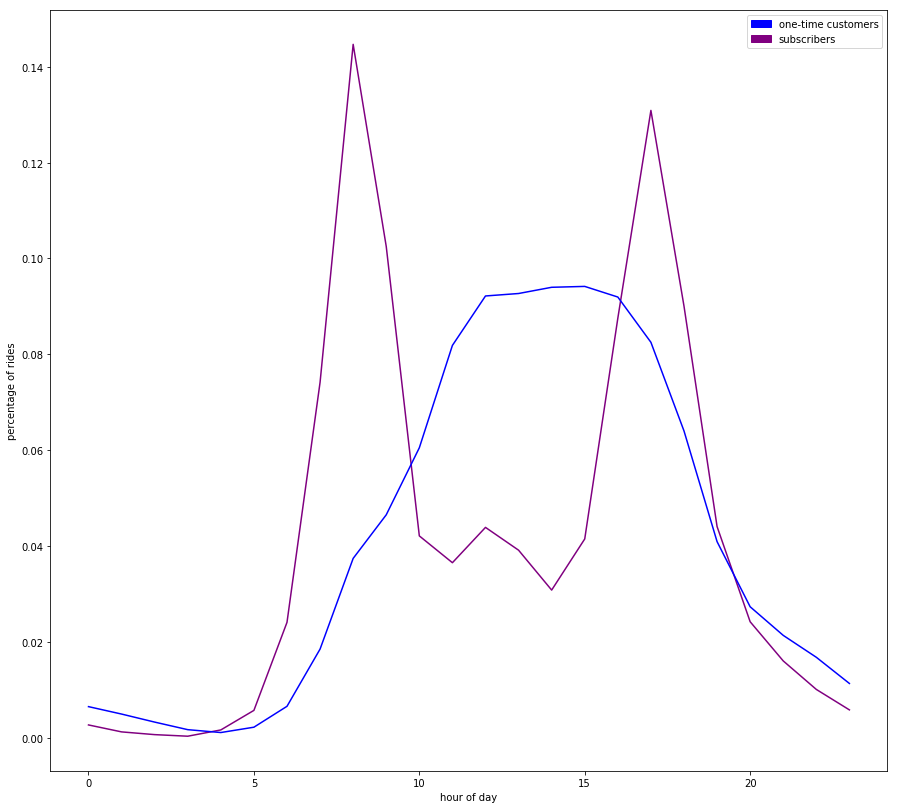

In [24]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams['figure.figsize'] = [15, 14]
plt.plot(sub_hods, sub_pcts, color='purple')
plt.plot(cust_hods, cust_pcts, color='blue')
plt.ylabel('percentage of rides')
plt.xlabel('hour of day')
bl = mpatches.Patch(color='blue', label='one-time customers')
pr = mpatches.Patch(color='purple', label='subscribers')
plt.legend(handles=[bl,pr])
plt.show()

In [25]:
cust_dow_percents_rows = (weather_trip
                    .groupBy('subscription_type', 'dow')
                    .agg({'*':'count'})
                    .withColumn('percentage', pctC(col('count(1)')))
                    .filter(col('subscription_type') == 'Customer')
                    .select('dow', 'percentage')
                    .sort('dow')
                    .collect()  
)
subs_dow_percents_rows = (weather_trip
                    .groupBy('subscription_type', 'dow')
                    .agg({'*':'count'})
                    .withColumn('percentage', pctS(col('count(1)')))
                    .filter(col('subscription_type') == 'Subscriber')
                    .select('dow', 'percentage')
                    .sort('dow')
                    .collect()  
)

In [26]:
cust_dows = []
cust_dow_percents = []
subs_dows = []
subs_dow_percents =[]
for item in cust_dow_percents_rows:
    cust_dows.append(item.dow)
    cust_dow_percents.append(item.percentage)
for item in subs_dow_percents_rows:
    subs_dows.append(item.dow)
    subs_dow_percents.append(item.percentage)

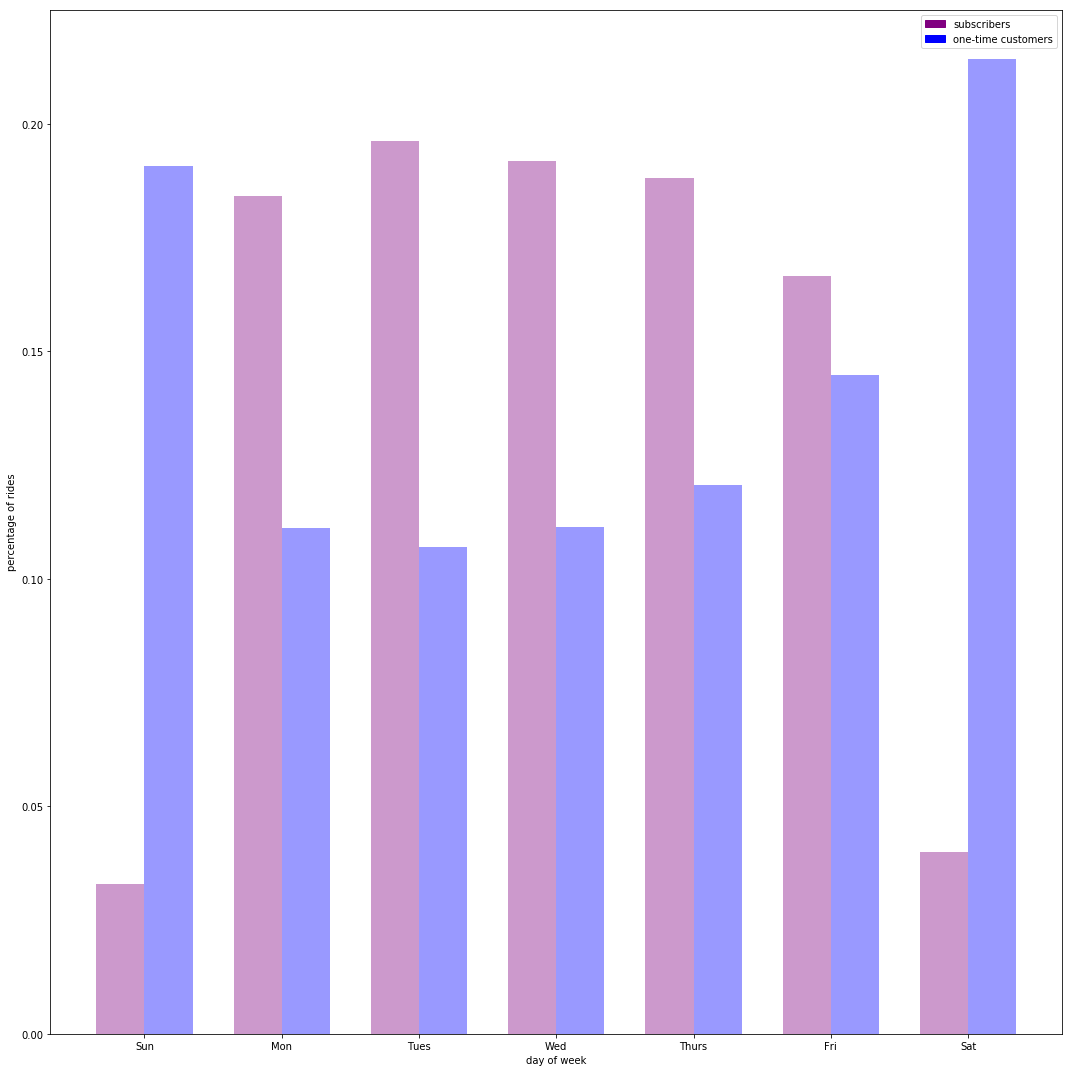

In [27]:
plt.rcParams['figure.figsize'] = [15, 15]
import numpy as np
index = np.arange(7) + 1
bar_width = 0.35
fig, ax = plt.subplots()
ax.bar(index, subs_dow_percents, bar_width, color='purple', alpha=0.4)
ax.bar(index + bar_width, cust_dow_percents, bar_width, color='blue', alpha=0.4)
ax.set_ylabel('percentage of rides')
ax.set_xlabel('day of week')
ax.set_xticks(index + bar_width / 2)
bl = mpatches.Patch(color='blue', label='one-time customers')
pr = mpatches.Patch(color='purple', label='subscribers')
ax.legend(handles=[pr, bl])
ax.set_xticklabels(('Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat'))
fig.tight_layout()
plt.show()

In [28]:
station_data = spark.read.csv(os.path.join(os.getcwd(), 'data/station.csv'),
                             header=True,
                             inferSchema=True,
                             timestampFormat="MM/dd/YYYY HH:mm")
loc_weather_trip = (weather_trip.drop('id').join(station_data.select('id', 'lat', 'long'), weather_trip.start_station_id == station_data.id)
 .drop('id')
 .withColumnRenamed('lat', 'start_lat')
 .withColumnRenamed('long', 'start_long')
 .join(station_data, weather_trip.end_station_id == station_data.id)
 .drop('id')
 .withColumnRenamed('lat', 'end_lat')
 .withColumnRenamed('long', 'end_long'))

In [29]:
intermed_cust = (loc_weather_trip
                 .filter(col('subscription_type') == 'Customer')
                 .groupBy('end_station_id', 'end_lat', 'end_long')
                 .agg({'*':'count'})
                 .withColumn('percentage', pctC(col('count(1)')) * 100)
                 .orderBy(desc('percentage'))
                 .select('end_lat', 'end_long', 'percentage')
                )
intermed_cust.show()

+------------------+-------------------+----------+
|           end_lat|           end_long|percentage|
+------------------+-------------------+----------+
|          37.80477|-122.40323400000001| 12.783274|
|         37.795392|        -122.394203|  8.298373|
|         37.786305|-122.40496599999999|  4.352165|
|37.783871000000005|        -122.408433| 3.9849632|
|         37.776617|-122.39526000000001|   3.79894|
|         37.799953|        -122.398525| 3.7718117|
|         37.794139|        -122.394434| 3.7582476|
|         37.788446|        -122.408499| 3.7136793|
|         37.780526|-122.39028799999998| 3.3367891|
|         37.798522|-122.40724499999999| 3.3009405|
|37.776619000000004|-122.41738500000001|  2.619825|
|         37.789625|        -122.400811| 2.4153936|
|         37.774814|        -122.418954| 2.2274327|
|         37.781039|        -122.411748|    2.0666|
|         37.787152|-122.38801299999999|  2.007499|
|37.784878000000006|-122.40101399999999|  1.918363|
|37.78175200

In [30]:
cust_lats = []
cust_longs = []
cust_station_pcts = []
for row in intermed_cust.collect():
    cust_lats.append(row.end_lat)
    cust_longs.append(row.end_long)
    cust_station_pcts.append(row.percentage)


In [31]:
intermed_subs = (loc_weather_trip
                 .filter(col('subscription_type') == 'Subscriber')
                 .groupBy('end_station_id', 'end_lat', 'end_long')
                 .agg({'*':'count'})
                 .withColumn('percentage', pctS(col('count(1)')) * 100)
                 .orderBy(desc('percentage'))
                 .select('end_lat', 'end_long', 'percentage')
                )
intermed_subs.show()

+------------------+-------------------+----------+
|           end_lat|           end_long|percentage|
+------------------+-------------------+----------+
|         37.776617|-122.39526000000001| 10.455831|
|           37.7766|-122.39546999999999| 5.8971744|
|         37.789625|        -122.400811|  4.506428|
|         37.780526|-122.39028799999998|  4.426145|
|37.771058000000004|        -122.402717|  4.389621|
|         37.795392|        -122.394203| 4.3455095|
|         37.789756|-122.39464299999999| 3.9303322|
|         37.794139|        -122.394434| 3.7311249|
|          37.80477|-122.40323400000001| 3.1058004|
|37.783871000000005|        -122.408433| 2.7851985|
|         37.782259|        -122.392738| 2.7237952|
|         37.786305|-122.40496599999999|  2.721325|
|37.776619000000004|-122.41738500000001| 2.6749196|
|37.781752000000004|-122.40512700000001| 2.2973254|
|37.786978000000005|-122.39810800000001| 2.2849743|
|         37.781039|        -122.411748| 2.1536984|
|37.79146400

In [32]:
subs_lats = []
subs_longs = []
subs_station_pcts = []
for row in intermed_subs.collect():
    subs_lats.append(row.end_lat)
    subs_longs.append(row.end_long)
    subs_station_pcts.append(row.percentage)

<IPython.core.display.Javascript object>


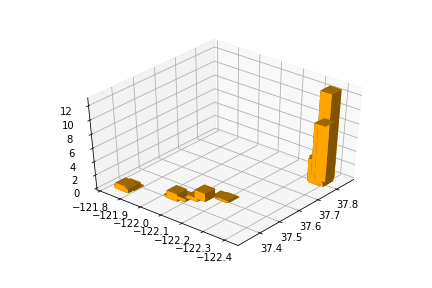

In [35]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

xs = cust_lats
ys = cust_longs
zs = [0] * len(xs)

dx = np.ones(len(cust_longs)) * .05
dy = np.ones(len(cust_lats)) * .05
dz = cust_station_pcts

xs2 = subs_lats
ys2 = subs_longs

dz2 = subs_station_pcts
#ax1.bar3d(xs2, ys2, zs, dx, dy, dz2, color='blue')
ax1.bar3d(xs, ys, zs, dx, dy, dz, color='orange')
plt.show()

<IPython.core.display.Javascript object>


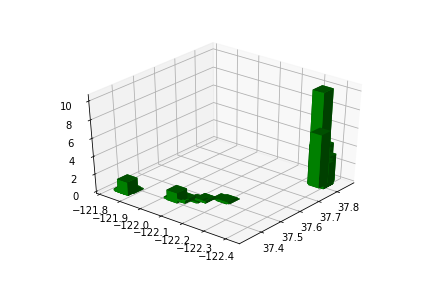

In [36]:
fig = plt.figure()
ax2 = fig.add_subplot(111, projection='3d')
ax2.bar3d(xs2, ys2, zs, dx, dy, dz2, color='green')